# Accessing Aeon Data on Ceph

In [12]:
import pandas as pd
import aeon.io.api as aeon
import matplotlib.pyplot as plt
from aeon.schema.dataset import exp01
from aeon.analysis.utils import *
from aeon.analysis.plotting import *
from functools import partial

In [7]:
root = "/ceph/aeon/aeon/data/raw/AEON/experiment0.1"
# load all sessions
events = aeon.load(root, exp01.SessionData)

In [8]:
# compute session duration
sessions = visits(events, onset="Start", offset="End")
# take only mouse sessions
sessions = sessions[sessions.id.str.startswith("BAA")]
# take only sessions after the 14th June
sessions = sessions[sessions.start >= pd.Timestamp("20210621")]
sessions = sessions[
    # take only sessions with more than 1h
    (sessions.duration > pd.Timedelta("1h"))
    # or where duration is NA (no ending)
    | sessions.duration.isna()
]
# take only sessions from specific mouse
sessions = sessions[sessions.id == "BAA-1099793"]

In [9]:
# pick a session
session = sessions.iloc[0]
# get session start and end
start, end = session.start, session.end
# format figure prefix
prefix = "{0}_{1}".format(session.id, start.date())
# get session data loader between start and end
sessiondata = partial(aeon.load, root, start=start, end=end)

# get position data
position = sessiondata(exp01.FrameTop.Position)
# get encoder data for patch1
encoder1 = sessiondata(exp01.Patch1.Encoder)
# get encoder data for patch2
encoder2 = sessiondata(exp01.Patch2.Encoder)
# get pellet events for patch1
pellets1 = sessiondata(exp01.Patch1.DeliverPellet)
# get pellet events for patch2
pellets2 = sessiondata(exp01.Patch2.DeliverPellet)
# get patch state for patch1 between start and end
state1 = sessiondata(exp01.Patch1.DepletionState)
# get patch state for patch2 between start and end
state2 = sessiondata(exp01.Patch2.DepletionState)

# compute total distance travelled on patch1 wheel
wheel1 = distancetravelled(encoder1.angle)
# compute total distance travelled on patch2 wheel
wheel2 = distancetravelled(encoder2.angle)

In [10]:
# frame rate in Hz
frequency = 50
# 1 px = 1.92 mm
pixelscale = 0.00192
# frame position range in metric units
positionrange = [[0, 1440 * pixelscale], [0, 1080 * pixelscale]]
if start > pd.Timestamp("20210621") and start < pd.Timestamp(
    "20210701"
):  # time offset to account for abnormal drop event
    # exact offset extracted from video timestamps
    position.index = position.index + pd.Timedelta("22.57966s")
# filter for objects of the correct size
valid_position = (position.area > 0) & (position.area < 1000)
# get only valid positions
position = position[valid_position]
# scale position data to metric units
position.x = position.x * pixelscale
position.y = position.y * pixelscale

In [11]:
# compute ethogram based on distance to patches, nest and corridor
radius = 0.95  # middle
inner = 0.93  # inner
outer = 0.97  # outer
patchradius = 0.21  # patch radius
x0, y0 = 1.475, 1.075  # center
p1x, p1y = 1.13, 1.59  # patch1
p2x, p2y = 1.19, 0.50  # patch2
p1x, p1y = p1x - 0.02, p1y + 0.07  # offset1
p2x, p2y = p2x - 0.04, p2y - 0.04  # offset2
dist0 = distance(position, (x0, y0))
distp1 = distance(position, (p1x, p1y))
distp2 = distance(position, (p2x, p2y))
in_corridor = (dist0 < outer) & (dist0 > inner)
in_nest = dist0 > outer
in_patch1 = activepatch(wheel1, distp1 < patchradius)
in_patch2 = activepatch(wheel2, distp2 < patchradius)
in_arena = ~in_corridor & ~in_nest & ~in_patch1 & ~in_patch2
ethogram = pd.Series("other", index=position.index)
ethogram[in_corridor] = "corridor"
ethogram[in_nest] = "nest"
ethogram[in_patch1] = "patch1"
ethogram[in_patch2] = "patch2"
ethogram[in_arena] = "arena"

## Plot heatmap of time spent in the arena

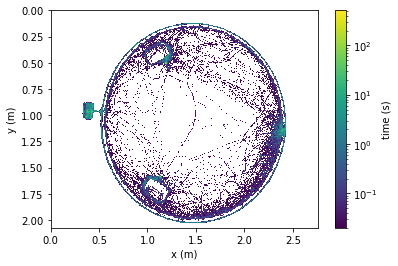

In [13]:
# plot heatmap of time spent in the arena
fig, ax = plt.subplots(1, 1)
heatmap(position, frequency, bins=500, range=positionrange, ax=ax)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.show()

## Plot foraging trajectories overlaid on top of heatmap

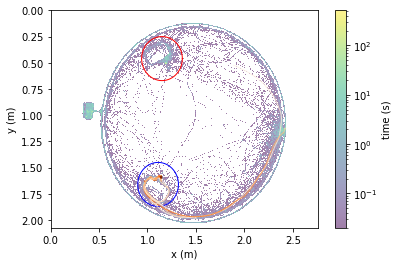

In [14]:
# plot foraging trajectories overlaid on top of heatmap
fig, ax = plt.subplots(1, 1)
heatmap(position, frequency, bins=500, range=positionrange, ax=ax, alpha=0.5)
circle(p1x, p1y, patchradius, "b", linewidth=1, ax=ax)
circle(p2x, p2y, patchradius, "r", linewidth=1, ax=ax)
# get position data when a pellet is delivered at patch1
forage = position.reindex(pellets1.index, method="pad")
for trial in pellets1.itertuples():  # for each pellet delivery
    # get the previous 10 seconds
    before = trial.Index - pd.to_timedelta(15, "s")
    # get position data in the time before pellet delivery
    path = position.loc[before : trial.Index]
    # plot path traces preceding pellet delivery
    colorline(path.x, path.y, cmap=plt.cm.Oranges, linewidth=1)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.show()

## Plot patch activity summary

/nfs/nhome/live/goncalolopes/.conda/envs/aeon_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


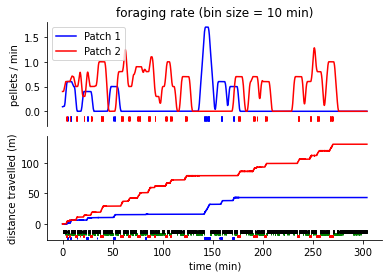

In [15]:
# plot patch activity summary including foraging rate, travelled distance and ethogram
fig = plt.figure()
rate_ax = fig.add_subplot(211)
distance_ax = fig.add_subplot(212)
ethogram_ax = fig.add_subplot(20, 1, 20)
rateplot(
    pellets1,
    "600s",
    frequency=500,
    weight=0.1,
    start=start,
    end=end,
    smooth="120s",
    color="b",
    label="Patch 1",
    ax=rate_ax,
)
rateplot(
    pellets2,
    "600s",
    frequency=500,
    weight=0.1,
    start=start,
    end=end,
    smooth="120s",
    color="r",
    label="Patch 2",
    ax=rate_ax,
)
# plot position data as a path trajectory
distance_ax.plot(sessiontime(wheel1.index), wheel1 / 100, "b")
# plot position data as a path trajectory
distance_ax.plot(sessiontime(wheel2.index), wheel2 / 100, "r")

# plot vertical line indicating change of patch state, e.g. threshold
change1 = state1[state1.threshold.diff().abs() > 0]
change2 = state2[state2.threshold.diff().abs() > 0]
change = pd.concat([change1, change2])
if len(change) > 0:
    ymin, ymax = distance_ax.get_ylim()
    distance_ax.vlines(
        sessiontime(change.index, start), ymin, ymax, linewidth=1, color="k"
    )

# plot ethogram
consecutive = (ethogram != ethogram.shift()).cumsum()
ethogram_colors = {
    "patch1": "blue",
    "patch2": "red",
    "arena": "green",
    "corridor": "black",
    "nest": "black",
}
ethogram_offsets = {
    "patch1": [0, 0.2],
    "patch2": [0.2, 0.2],
    "arena": [0.4, 0.2],
    "corridor": [0.6, 0.2],
    "nest": [0.6, 0.2],
}
ethogram_ranges = ethogram.groupby(by=[ethogram, consecutive]).apply(
    lambda x: [sessiontime(x.index[0], start), sessiontime(x.index[-1], x.index[0])]
)
for key, ranges in ethogram_ranges.groupby(level=0):
    color = ethogram_colors[key]
    offsets = ethogram_offsets[key]
    ethogram_ax.broken_barh(ranges, offsets, color=color)

rate_ax.legend()
rate_ax.sharex(distance_ax)
rate_ax.tick_params(bottom=False, labelbottom=False)
fig.subplots_adjust(hspace=0.1)
rate_ax.set_ylabel("pellets / min")
rate_ax.set_title("foraging rate (bin size = 10 min)")
distance_ax.set_xlabel("time (min)")
distance_ax.set_ylabel("distance travelled (m)")
set_ymargin(distance_ax, 0.2, 0.1)
rate_ax.spines["top"].set_visible(False)
rate_ax.spines["right"].set_visible(False)
rate_ax.spines["bottom"].set_visible(False)
distance_ax.spines["top"].set_visible(False)
distance_ax.spines["right"].set_visible(False)
ethogram_ax.set_axis_off()
plt.show()